In [3]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)
from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from minepy import MINE

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,accuracy_score,auc,roc_curve,recall_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

In [4]:
### Alexa Output

# path = '../../../../reputation/http_dom_javascript_experiment/alexa_output/'
# lst = os.listdir(path)
# number_files = len(lst)
# print(number_files) 

# df=pd.DataFrame()
# lst=[]
# i=0
# for filename in os.listdir(path):
#     i=i+1
#     if(i%10==0):
#         print(i)
#     file=open(path+filename,'r')
#     text=file.read()
#     try:
#         json_content=json.loads(text)
#         temp_df=pd.DataFrame.from_dict(json_normalize(json_content),orient='columns')
#         df=pd.concat([df,temp_df],axis=0,ignore_index=True,sort=True)
#     except:
#         lst.append(filename)

# df.head()

# df.to_csv('Javascript_alexa_output.csv')

# def file_is_empty(filename):
#     path = '../../../../reputation/http_dom_javascript_experiment/alexa_output/'
#     path_file=path+filename
#     return os.stat(path_file).st_size==0

# i=0
# for file in lst:
#     path = '../../../../reputation/http_dom_javascript_experiment/alexa_output/'
#     if os.stat(path+file).st_size==0:
#         i=i+1

# pd.Series(lst).to_csv('Empty_file.csv')

# ### Malicious Output

# path = '../../../../reputation/http_dom_javascript_experiment/malicious_output/'
# lst = os.listdir(path)
# number_files = len(lst)
# print(number_files) 

# df=pd.DataFrame()
# lst=[]
# i=0
# for filename in os.listdir(path):
#     i=i+1
# #     if(i%1000==0):
# #         print(i)
#     file=open(path+filename,'r')
#     text=file.read()
#     try:
#         json_content=json.loads(text)
#         temp_df=pd.DataFrame.from_dict(json_normalize(json_content),orient='columns')
#         df=pd.concat([df,temp_df],axis=0,ignore_index=True,sort=True)
#     except:
#         lst.append(filename)

# df.to_csv('Javascript_malicious_output.csv')

# i=0
# for file in lst:
#     if os.stat(path+file).st_size==0:
#         i=i+1

# pd.Series(lst).to_csv('Empty_file_malicious.csv')

In [5]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1,verbose=False)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    display(cm_train)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    display(cm_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

def grid_f1(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='f1',cv=kfold,n_jobs=-1,verbose=False)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    display(cm_train)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    display(cm_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc


from keras import backend as K


### stackoverflow add reference
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Eliminating cases where html_status=="Not success" as they have all null values

In [6]:
df_alex=pd.read_csv('Javascript_alexa_output.csv',low_memory=False)
df_virus=pd.read_csv('Javascript_malicious_output.csv',low_memory=False)

df_alex['Malicious']=0
df_virus['Malicious']=1

df=pd.concat([df_alex,df_virus])

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df = df.sample(frac=1,random_state=867).reset_index(drop=True)

df.fillna(value=0,inplace=True)

display(df.shape)

df=df[df['html_status']=='Success']


### Dropping columns that indicate the html status of domain data collection

df.drop(['html_status','html_status_strerror','html_status_message'],axis=1,inplace=True)
df.set_index(['domain'],inplace=True)

cols_WebAssembly=[col for col in df.columns if 'js_function_WebAssembly' in col]
cols_Reflect=[col for col in df.columns if 'Reflect' in col]
cols_Object=[col for col in df.columns if 'js_function_Object' in col]
cols_Number=[col for col in df.columns if 'js_function_Number' in col]
cols_Math=[col for col in df.columns if 'js_function_Math' in col]
cols_Atomics=[col for col in df.columns if 'js_function_Atomics' in col]
cols_Promise=[col for col in df.columns if 'Promise' in col]



df['tot_WebAssembly']=df[cols_WebAssembly].sum(axis=1)
df['tot_Reflect']=df[cols_Reflect].sum(axis=1)
df['tot_Object']=df[cols_Object].sum(axis=1)
df['tot_Number']=df[cols_Number].sum(axis=1)
df['tot_Math']=df[cols_Math].sum(axis=1)
df['tot_Atomics']=df[cols_Atomics].sum(axis=1)
df['tot_Promise']=df[cols_Atomics].sum(axis=1)

len(cols_WebAssembly)+len(cols_Reflect)+len(cols_Object)+len(cols_Number)+len(cols_Math)+len(cols_Atomics)+len(cols_Promise)

cols_document=[col for col in df.columns if 'document' in col]
df['tot_document']=df[cols_document].sum(axis=1)

cols_window=[col for col in df.columns if 'window' in col]
df['tot_window']=df[cols_window].sum(axis=1)

df.shape
# df.to_csv('Javascript_dom.csv')

df.head()

(46958, 411)

,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

### With Features referred to in other papers

escape()
JS - unescape()
JS - eval()
JS - concat()
JS - charCodeAt()
JS - fromCharCode()
JS - split()
JS - parseInt()
JS - replace()
JS - link()
JS - exec()
JS - search()
JS - substring()


### 1.a. No under/over-sampling

In [72]:
X=df[['js_function_escape)','js_function_unescape(','js_function_eval(','js_function_.concat(','js_function_.charCodeAt(',
   'js_function_String.fromCharCode(','js_function_.split(','js_function_Number.parseInt(','js_function_.replace(',
   'js_function_.link(','js_function_.exec(','js_function_.search(','js_function_.substring(']]
y=df.Malicious.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(44450, 13)

#### 1.a.a. Optimized on acuuracy

##### 1.a.a.a Deep learning

In [75]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_test)

The accuracy of the model on training data is: 0.8407761529808774


Predicted  False  True  __all__
Actual                         
False      29894     0    29894
True        5662     4     5666
__all__    35556     4    35560

The accuracy of the model on test data is: 0.8343082114735658


Predicted     0  1  __all__
Actual                     
0          7417  0     7417
1          1473  0     1473
__all__    8890  0     8890

##### 1.a.a.b Gradient Boosted Trees

In [77]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,10,0.1,100,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8410011248593926

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False      29890     4    29894
True        5650    16     5666
__all__    35540    20    35560

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8343082114735658

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          7417  0     7417
1          1473  0     1473
__all__    8890  0     8890

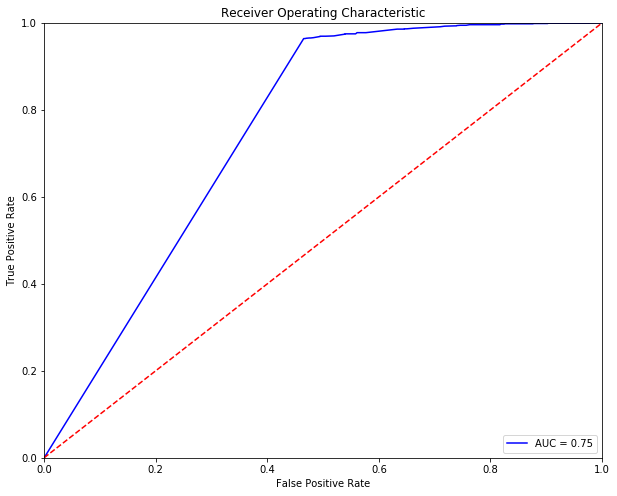

Optimal Threshold is 0.27233004062743366
Accuracy on test data is: 0.8341957255343082


Predicted  False  True  __all__
Actual                         
False       7416     1     7417
True        1473     0     1473
__all__     8889     1     8890

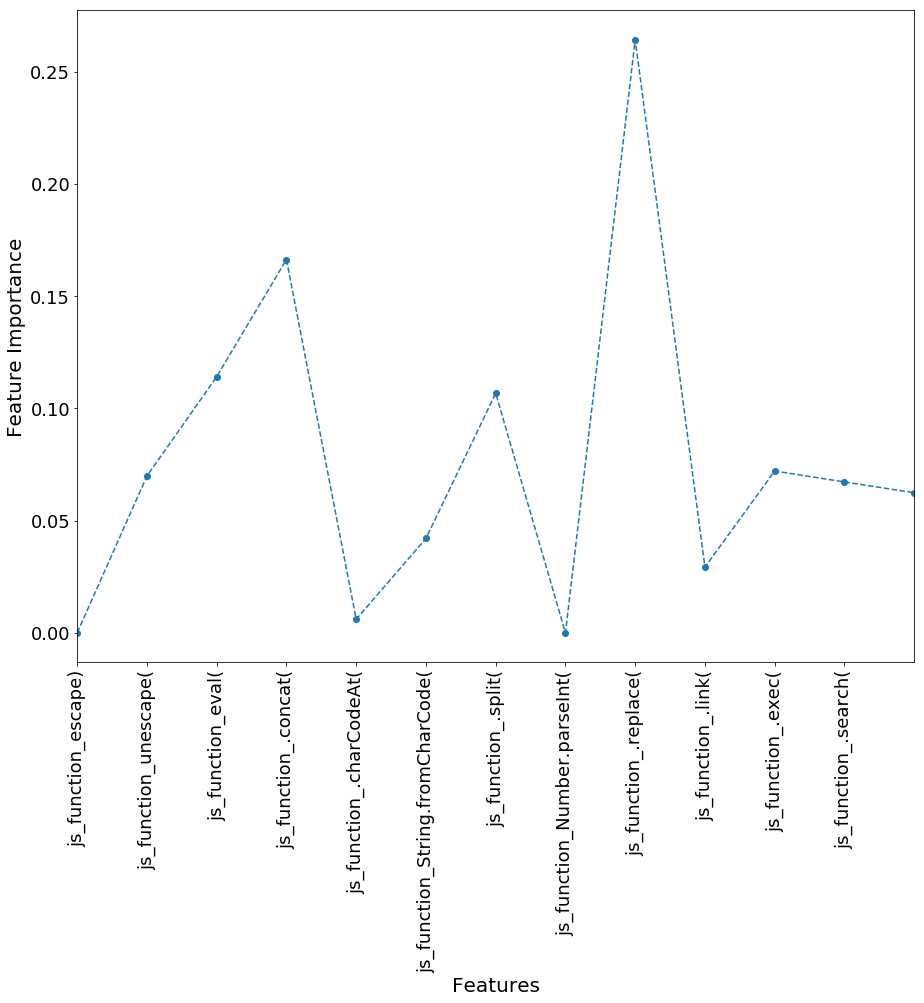

In [78]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),feature_name,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### 1.a.b Optimized on f1 score 

##### 1.a.b.a Deep learning

In [80]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=[f1])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=accuracy_score(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False))
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.840748031496063


Predicted  False  True  __all__
Actual                         
False      29894     0    29894
True        5663     3     5666
__all__    35557     3    35560

The accuracy of the model on test data is: 0.8343082114735658


Predicted     0  1  __all__
Actual                     
0          7417  0     7417
1          1473  0     1473
__all__    8890  0     8890

##### 1.a.b.b GBC

In [81]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_f1(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,10,0.1,100,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8410011248593926

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False      29890     4    29894
True        5650    16     5666
__all__    35540    20    35560

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8343082114735658

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          7417  0     7417
1          1473  0     1473
__all__    8890  0     8890

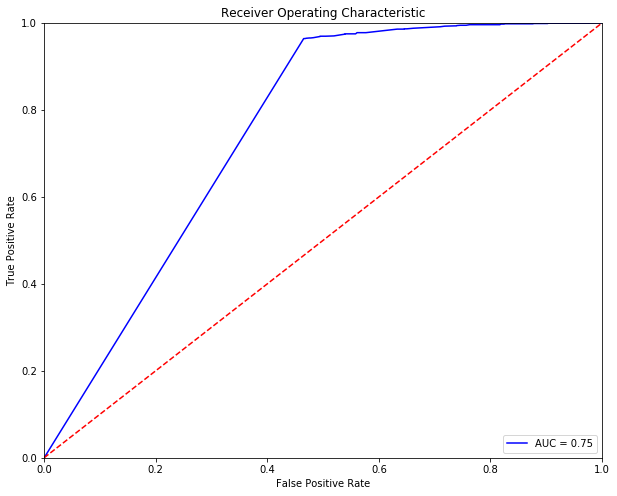

Optimal Threshold is 0.27233004062743366
Accuracy on test data is: 0.8341957255343082


Predicted  False  True  __all__
Actual                         
False       7416     1     7417
True        1473     0     1473
__all__     8889     1     8890

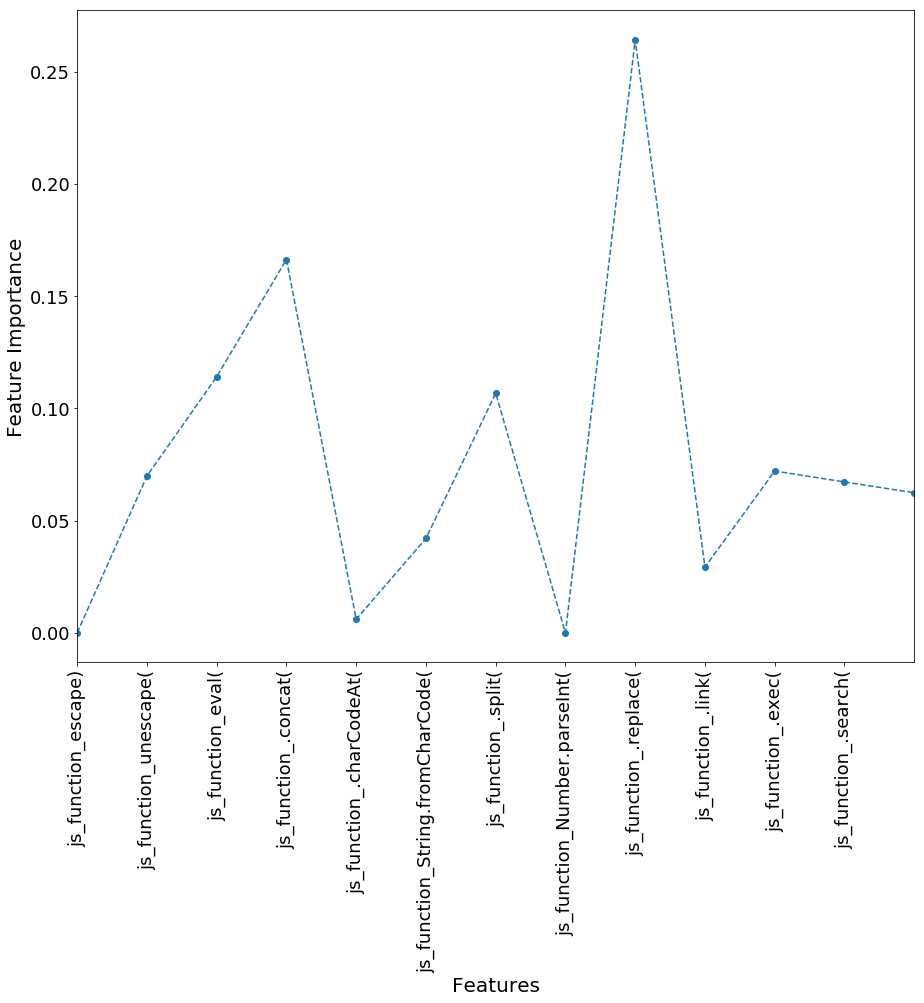

In [82]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),feature_name,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

### 1.b. With oversampling using <a href='https://jair.org/index.php/jair/article/view/10302'>SMOTE</a> technique

In [83]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
x_train, X_test, y_train, Y_test = train_test_split(X, y,test_size=0.2,random_state=12)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(x_train, y_train)

#### 1.b.a. Optimized on accuracy

##### 1.b.a.a. Deep Learning

In [86]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.746471317933416


Predicted  False   True  __all__
Actual                          
False      15540  14287    29827
True         837  28990    29827
__all__    16377  43277    59654

The accuracy of the model on test data is: 0.5977502812148482


Predicted  False  True  __all__
Actual                         
False       3961  3523     7484
True          53  1353     1406
__all__     4014  4876     8890

##### 1.b.a.b GBC

In [87]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,5,0.1,150,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.7469574546551782

Confusion Matrix for Training data is:


Predicted  False   True  __all__
Actual                          
False      15606  14221    29827
True         874  28953    29827
__all__    16480  43174    59654

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.6004499437570304

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       3987  3497     7484
True          55  1351     1406
__all__     4042  4848     8890

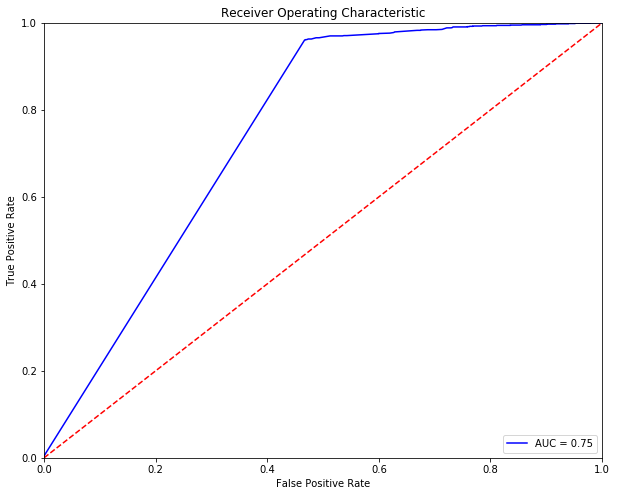

Optimal Threshold is 0.6638592439738271
Accuracy on test data is: 0.8424071991001125


Predicted  False  True  __all__
Actual                         
False       7482     2     7484
True        1399     7     1406
__all__     8881     9     8890

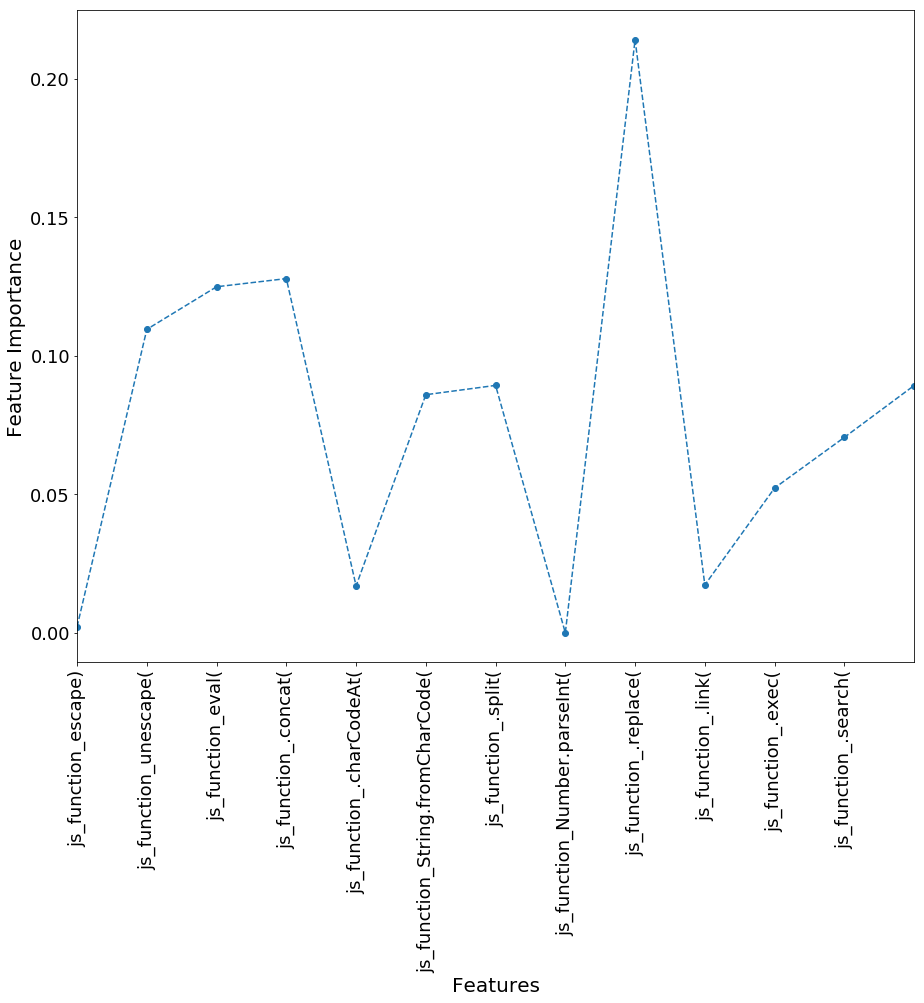

In [88]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),feature_name,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### 1.b.b Optimized on f1 score

##### 1.b.b.a Deep Learning

In [89]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=[f1])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=accuracy_score(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False))
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.7465718979448152


Predicted  False   True  __all__
Actual                          
False      15535  14292    29827
True         826  29001    29827
__all__    16361  43293    59654

The accuracy of the model on test data is: 0.5980877390326209


Predicted  False  True  __all__
Actual                         
False       3962  3522     7484
True          51  1355     1406
__all__     4013  4877     8890

##### 1.b.b.b GBC

In [90]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_f1(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,5,0.1,150,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.7469574546551782

Confusion Matrix for Training data is:


Predicted  False   True  __all__
Actual                          
False      15606  14221    29827
True         874  28953    29827
__all__    16480  43174    59654

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.6004499437570304

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       3987  3497     7484
True          55  1351     1406
__all__     4042  4848     8890

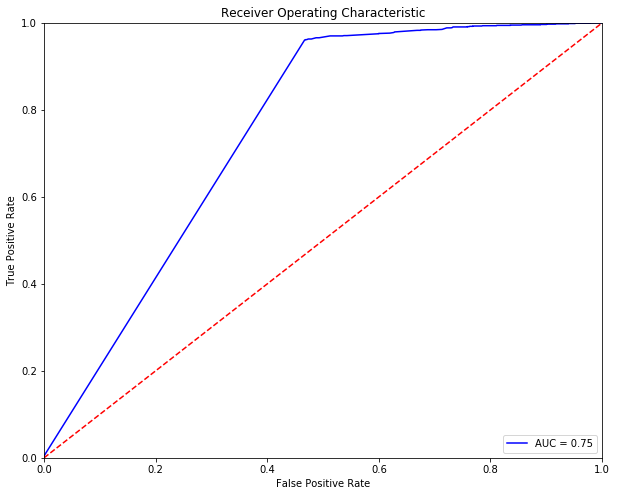

Optimal Threshold is 0.6638592439738271
Accuracy on test data is: 0.8424071991001125


Predicted  False  True  __all__
Actual                         
False       7482     2     7484
True        1399     7     1406
__all__     8881     9     8890

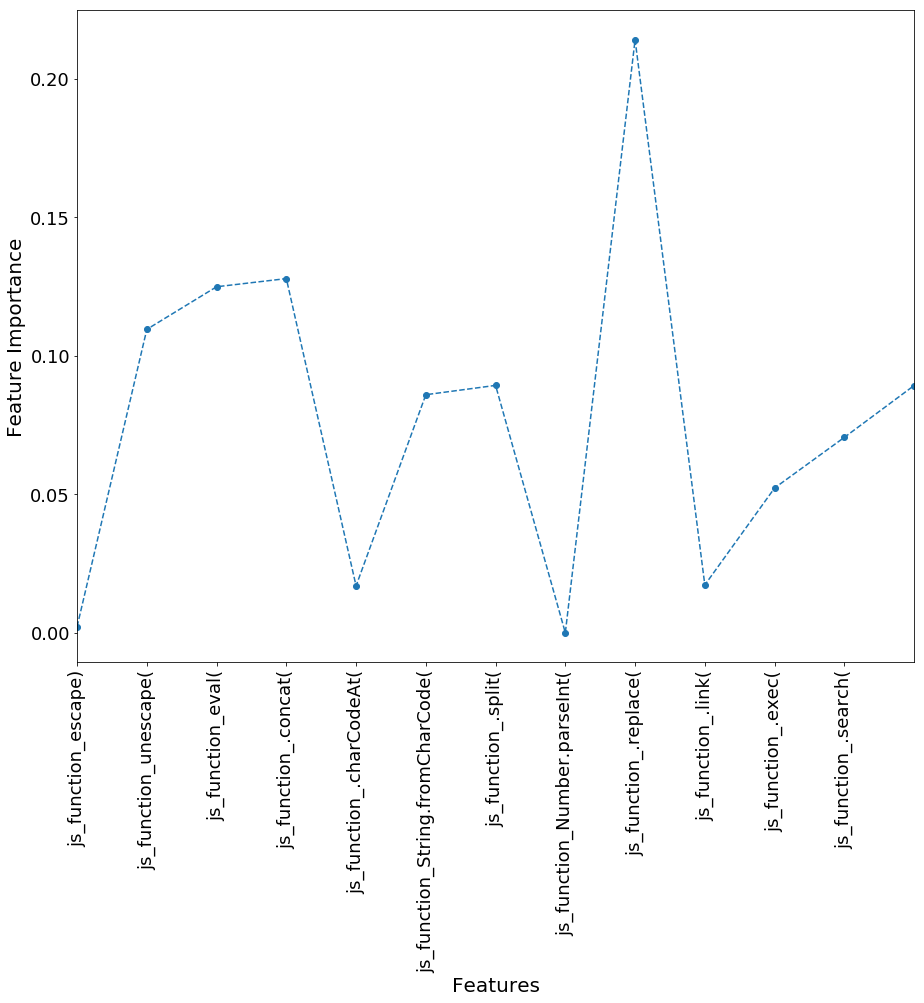

In [92]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),feature_name,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

### 1.c. With undersampling

In [93]:
df_non=df[df.Malicious==0]
df_mal=df[df.Malicious==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Malicious.value_counts() 

1    7139
0    7139
Name: Malicious, dtype: int64

In [94]:
X=df_u[['js_function_escape)','js_function_unescape(','js_function_eval(','js_function_.concat(','js_function_.charCodeAt(',
   'js_function_String.fromCharCode(','js_function_.split(','js_function_Number.parseInt(','js_function_.replace(',
   'js_function_.link(','js_function_.exec(','js_function_.search(','js_function_.substring(']]
y=df_u.Malicious.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(14278, 13)

#### 1.c.c Optimized with accuracy

##### 1.c.c.a Deep Learning

In [95]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=1200,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.7433023989524133


Predicted  False  True  __all__
Actual                         
False       2974  2771     5745
True         161  5516     5677
__all__     3135  8287    11422

The accuracy of the model on test data is: 0.7461484593837535


Predicted  False  True  __all__
Actual                         
False        711   683     1394
True          42  1420     1462
__all__      753  2103     2856

##### 1.c.c.b GBC

In [96]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[200,300], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,10,0.1,300,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.7406758886359657

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2981  2764     5745
True         198  5479     5677
__all__     3179  8243    11422

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.7457983193277311

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        716   678     1394
True          48  1414     1462
__all__      764  2092     2856

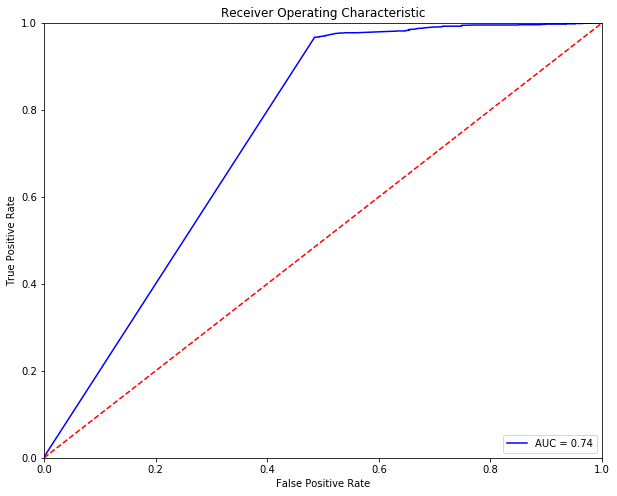

Optimal Threshold is 0.6619355538819609
Accuracy on test data is: 0.4891456582633053


Predicted  False  True  __all__
Actual                         
False       1394     0     1394
True        1459     3     1462
__all__     2853     3     2856

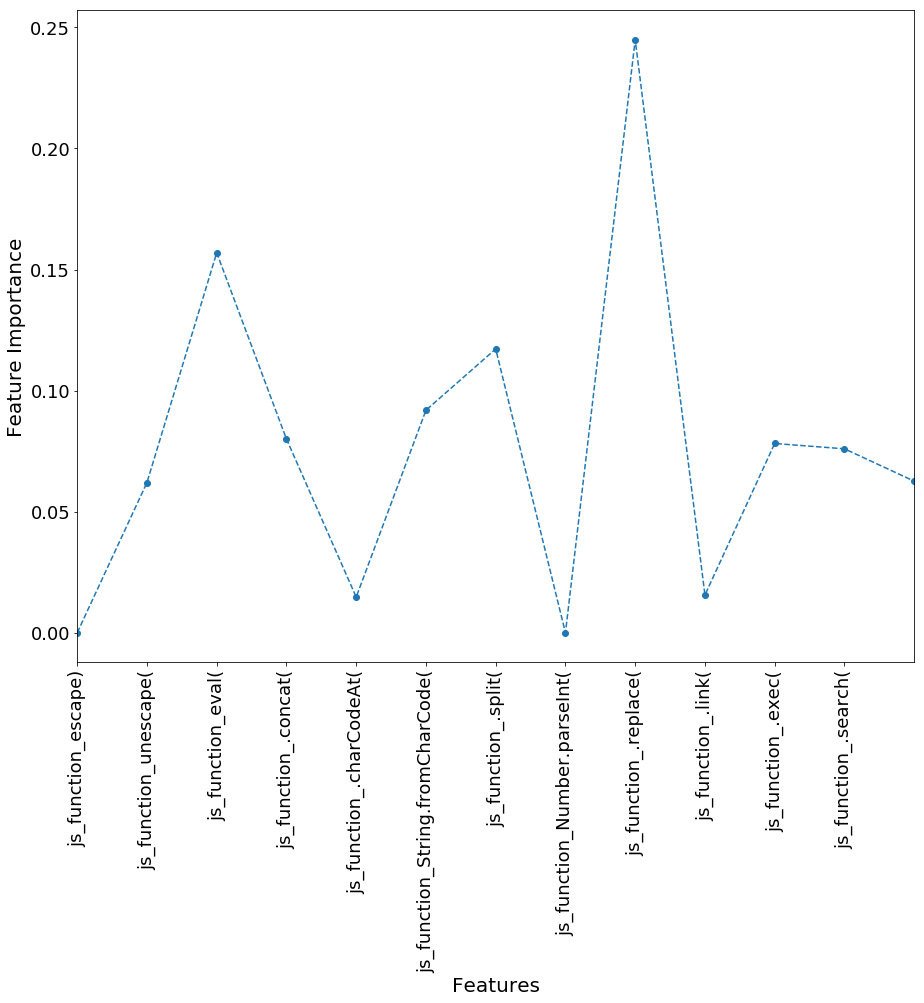

In [97]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),feature_name,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

### 2. With features we selected

In [7]:
X=df[['js_function_.add(',
 'js_function_.all(',
 'js_function_.allTrue(',
 'js_function_.anchor(',
 'js_function_.apply(',
 'js_function_.big(',
 'js_function_.bind(',
 'js_function_.blink(',
 'js_function_.bold(',
 'js_function_.call(',
 'js_function_.catch(',
 'js_function_.charAt(',
 'js_function_.charCodeAt(',
 'js_function_.clear(',
 'js_function_.codePointAt(',
 'js_function_.compile(',
 'js_function_.concat(',
 'js_function_.construct(',
 'js_function_.copyWithin(',
 'js_function_.defineProperty(',
 'js_function_.delete(',
 'js_function_.deleteProperty(',
 'js_function_.endWith(',
 'js_function_.entries(',
 'js_function_.every(',
 'js_function_.exec(',
 'js_function_.fill(',
 'js_function_.filter(',
 'js_function_.finally(',
 'js_function_.find(',
 'js_function_.findIndex(',
 'js_function_.fixed(',
 'js_function_.flat(',
 'js_function_.flatMap(',
 'js_function_.fontcolor(',
 'js_function_.fontsize(',
 'js_function_.forEach(',
 'js_function_.formatToParts(',
 'js_function_.from(',
 'js_function_.get(',
 'js_function_.getDate(',
 'js_function_.getDay(',
 'js_function_.getFloat32(',
 'js_function_.getFloat64(',
 'js_function_.getFullYear(',
 'js_function_.getHours(',
 'js_function_.getInt16(',
 'js_function_.getInt32(',
 'js_function_.getInt8(',
 'js_function_.getMilliseconds(',
 'js_function_.getMinutes(',
 'js_function_.getMonth(',
 'js_function_.getOwnPropertyDescriptor(',
 'js_function_.getPrototypeOf(',
 'js_function_.getSeconds(',
 'js_function_.getTime(',
 'js_function_.getTimezoneOffset(',
 'js_function_.getUTCDate(',
 'js_function_.getUTCDay(',
 'js_function_.getUTCFullYear(',
 'js_function_.getUTCHours(',
 'js_function_.getUTCMilliseconds(',
 'js_function_.getUTCMinutes(',
 'js_function_.getUTCMonth(',
 'js_function_.getUTCSeconds(',
 'js_function_.getUint16(',
 'js_function_.getUint32(',
 'js_function_.getUint8(',
 'js_function_.getYear(',
 'js_function_.grow(',
 'js_function_.has(',
 'js_function_.hasOwnProperty(',
 'js_function_.includes(',
 'js_function_.indexOf(',
 'js_function_.isExtensible(',
 'js_function_.isNan(',
 'js_function_.isPrototypeOf(',
 'js_function_.italics(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.lastIndexOf(',
 'js_function_.link(',
 'js_function_.localeCompare(',
 'js_function_.log(',
 'js_function_.map(',
 'js_function_.match(',
 'js_function_.min(',
 'js_function_.next(',
 'js_function_.normalize(',
 'js_function_.of(',
 'js_function_.ownKeys(',
 'js_function_.padEnd(',
 'js_function_.padStart(',
 'js_function_.pop(',
 'js_function_.preventExtensions(',
 'js_function_.propertyIsEnumerable(',
 'js_function_.push(',
 'js_function_.reduce(',
 'js_function_.reduceRight(',
 'js_function_.repeat(',
 'js_function_.replace(',
 'js_function_.resolvedOptions(',
 'js_function_.return(',
 'js_function_.reverse(',
 'js_function_.search(',
 'js_function_.select(',
 'js_function_.set(',
 'js_function_.setDate(',
 'js_function_.setFloat32(',
 'js_function_.setFloat64(',
 'js_function_.setFullYear(',
 'js_function_.setHours(',
 'js_function_.setInt16(',
 'js_function_.setInt32(',
 'js_function_.setInt8(',
 'js_function_.setMilliseconds(',
 'js_function_.setMinutes(',
 'js_function_.setMonth(',
 'js_function_.setPrototypeOf(',
 'js_function_.setSeconds(',
 'js_function_.setTime(',
 'js_function_.setUTCDate(',
 'js_function_.setUTCFullYear(',
 'js_function_.setUTCHours(',
 'js_function_.setUTCMilliseconds(',
 'js_function_.setUTCMinutes(',
 'js_function_.setUTCMonth(',
 'js_function_.setUTCSeconds(',
 'js_function_.setUint16(',
 'js_function_.setUint32(',
 'js_function_.setUint8(',
 'js_function_.setYear(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.small(',
 'js_function_.some(',
 'js_function_.sort(',
 'js_function_.splice(',
 'js_function_.split(',
 'js_function_.strike(',
 'js_function_.subarray(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.supportedLocalesOf(',
 'js_function_.test(',
 'js_function_.throw(',
 'js_function_.toDateString(',
 'js_function_.toExponential(',
 'js_function_.toFixed(',
 'js_function_.toISOString(',
 'js_function_.toJSON(',
 'js_function_.toLocaleString(',
 'js_function_.toLocaleTimeString(',
 'js_function_.toLocaleUpperCase(',
 'js_function_.toLowerCase(',
 'js_function_.toPrecision(',
 'js_function_.toSource(',
 'js_function_.toString(',
 'js_function_.toUpperCase(',
 'js_function_.trim(',
 'js_function_.trimEnd(',
 'js_function_.trimStart(',
 'js_function_.unshift(',
 'js_function_.valueOf(',
 'js_function_.values(',
 'js_function_Array.from(',
 'js_function_Array.isArray(',
 'js_function_Array.of(',
 'js_function_ArrayBuffer.isView(',
 'js_function_ArrayBuffer.transfer(',
 'js_function_Atomics.add(',
 'js_function_Atomics.and(',
 'js_function_Atomics.compareExchange(',
 'js_function_Atomics.exchange(',
 'js_function_Atomics.isLockFree(',
 'js_function_Atomics.load(',
 'js_function_Atomics.or(',
 'js_function_Atomics.store(',
 'js_function_Atomics.sub(',
 'js_function_Atomics.wait(',
 'js_function_Atomics.wake(',
 'js_function_Atomics.xor(',
 'js_function_Date.UTC(',
 'js_function_Date.now(',
 'js_function_Date.parse(',
 'js_function_Intl.getCanonicalLocales(',
 'js_function_JSON.parse(',
 'js_function_JSON.stringify(',
 'js_function_Math.abs(',
 'js_function_Math.acos(',
 'js_function_Math.acosh(',
 'js_function_Math.asin(',
 'js_function_Math.asinh(',
 'js_function_Math.atan(',
 'js_function_Math.atan2(',
 'js_function_Math.atanh(',
 'js_function_Math.cbrt(',
 'js_function_Math.ceil(',
 'js_function_Math.clz32(',
 'js_function_Math.cos(',
 'js_function_Math.cosh(',
 'js_function_Math.exp(',
 'js_function_Math.expm1(',
 'js_function_Math.floor(',
 'js_function_Math.fround(',
 'js_function_Math.hypot(',
 'js_function_Math.imul(',
 'js_function_Math.log(',
 'js_function_Math.log10(',
 'js_function_Math.log1p(',
 'js_function_Math.log2(',
 'js_function_Math.max(',
 'js_function_Math.min(',
 'js_function_Math.pow(',
 'js_function_Math.random(',
 'js_function_Math.round(',
 'js_function_Math.sign(',
 'js_function_Math.sin(',
 'js_function_Math.sinh(',
 'js_function_Math.sqrt(',
 'js_function_Math.tan(',
 'js_function_Math.tanh(',
 'js_function_Math.trunc(',
 'js_function_Number.isFinite(',
 'js_function_Number.isInteger(',
 'js_function_Number.isNaN(',
 'js_function_Number.isSafeInteger(',
 'js_function_Number.parseFloat(',
 'js_function_Number.parseInt(',
 'js_function_Object.assign(',
 'js_function_Object.create(',
 'js_function_Object.defineProperties(',
 'js_function_Object.defineProperty(',
 'js_function_Object.entries(',
 'js_function_Object.freeze(',
 'js_function_Object.getOwnPropertyDescriptor(',
 'js_function_Object.getOwnPropertyDescriptors(',
 'js_function_Object.getOwnPropertyNames(',
 'js_function_Object.getOwnPropertySymbols(',
 'js_function_Object.getPrototypeOf(',
 'js_function_Object.is(',
 'js_function_Object.isExtensible(',
 'js_function_Object.isFrozen(',
 'js_function_Object.isSealed(',
 'js_function_Object.keys(',
 'js_function_Object.preventExtensions(',
 'js_function_Object.seal(',
 'js_function_Object.setPrototypeOf(',
 'js_function_Promise.all(',
 'js_function_Promise.race(',
 'js_function_Promise.reject(',
 'js_function_Promise.resolve(',
 'js_function_Proxy.revocable(',
 'js_function_Reflect.apply(',
 'js_function_Reflect.construct(',
 'js_function_Reflect.defineProperty(',
 'js_function_Reflect.deleteProperty(',
 'js_function_Reflect.get(',
 'js_function_Reflect.getOwnPropertyDescriptor(',
 'js_function_Reflect.getPrototypeOf(',
 'js_function_Reflect.has(',
 'js_function_Reflect.isExtensible(',
 'js_function_Reflect.ownKeys(',
 'js_function_Reflect.preventExtensions(',
 'js_function_Reflect.set(',
 'js_function_Reflect.setPrototypeOf(',
 'js_function_String.fromCharCode(',
 'js_function_String.fromCodePoint(',
 'js_function_String.raw(',
 'js_function_Symbol.for(',
 'js_function_Symbol.keyFor(',
 'js_function_WebAssembly.compile(',
 'js_function_WebAssembly.compileStreaming(',
 'js_function_WebAssembly.customerSections(',
 'js_function_WebAssembly.exports(',
 'js_function_WebAssembly.imports(',
 'js_function_WebAssembly.instantiate(',
 'js_function_WebAssembly.instantiateStreaming(',
 'js_function_WebAssembly.validate(',
 'js_function_decodeURI(',
 'js_function_decodeURIComponent(',
 'js_function_encodeURI(',
 'js_function_encodeURIComponent(',
 'js_function_escape)',
 'js_function_eval(',
 'js_function_isFinite(',
 'js_function_isNaN(',
 'js_function_parseFloat(',
 'js_function_parseInt(',
 'js_function_undefined(',
 'js_function_unescape(',
 'js_function_uneval(',
 'number_functions_declared',
 'number_of_cookies',
 'number_of_http_only_cookies',
 'number_of_non_http_only_cookies',
 'number_of_secure_cookies',
 'number_of_unsecure_cookies']]

In [8]:
y=df.Malicious.values
feature_name = X.columns.tolist()

In [9]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)


X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()


rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()


embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()


feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

### 2.a. No under/over-sampling

In [102]:
X=df[feature_selection_df[feature_selection_df.Total==4]['Feature']]
y=df.Malicious.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(44450, 62)

#### 2.a.a. Optimized on acuuracy

##### 2.a.a.a Deep learning

In [103]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=62))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8780933633295838


Predicted  False  True  __all__
Actual                         
False      26274  3620    29894
True         715  4951     5666
__all__    26989  8571    35560

The accuracy of the model on test data is: 0.875140607424072


Predicted  False  True  __all__
Actual                         
False       6513   904     7417
True         206  1267     1473
__all__     6719  2171     8890

##### 2.a.a.b Gradient Boosted Trees

In [104]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,5,0.1,150,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.878599550056243

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False      26257  3637    29894
True         680  4986     5666
__all__    26937  8623    35560

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8760404949381327

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6506   911     7417
True         191  1282     1473
__all__     6697  2193     8890

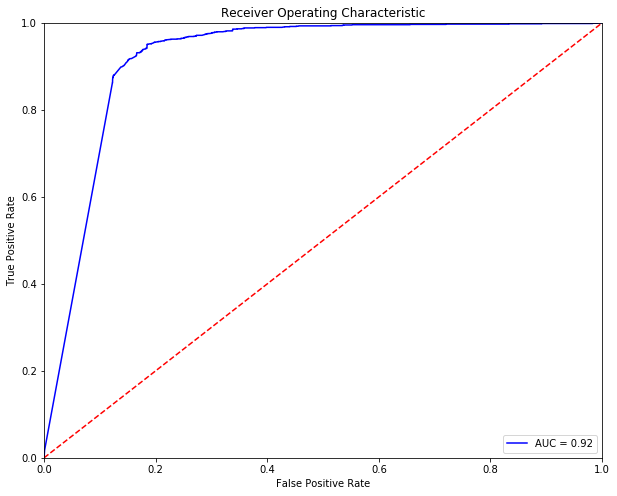

Optimal Threshold is 0.3803860742529919
Accuracy on test data is: 0.876265466816648


Predicted  False  True  __all__
Actual                         
False       6500   917     7417
True         183  1290     1473
__all__     6683  2207     8890

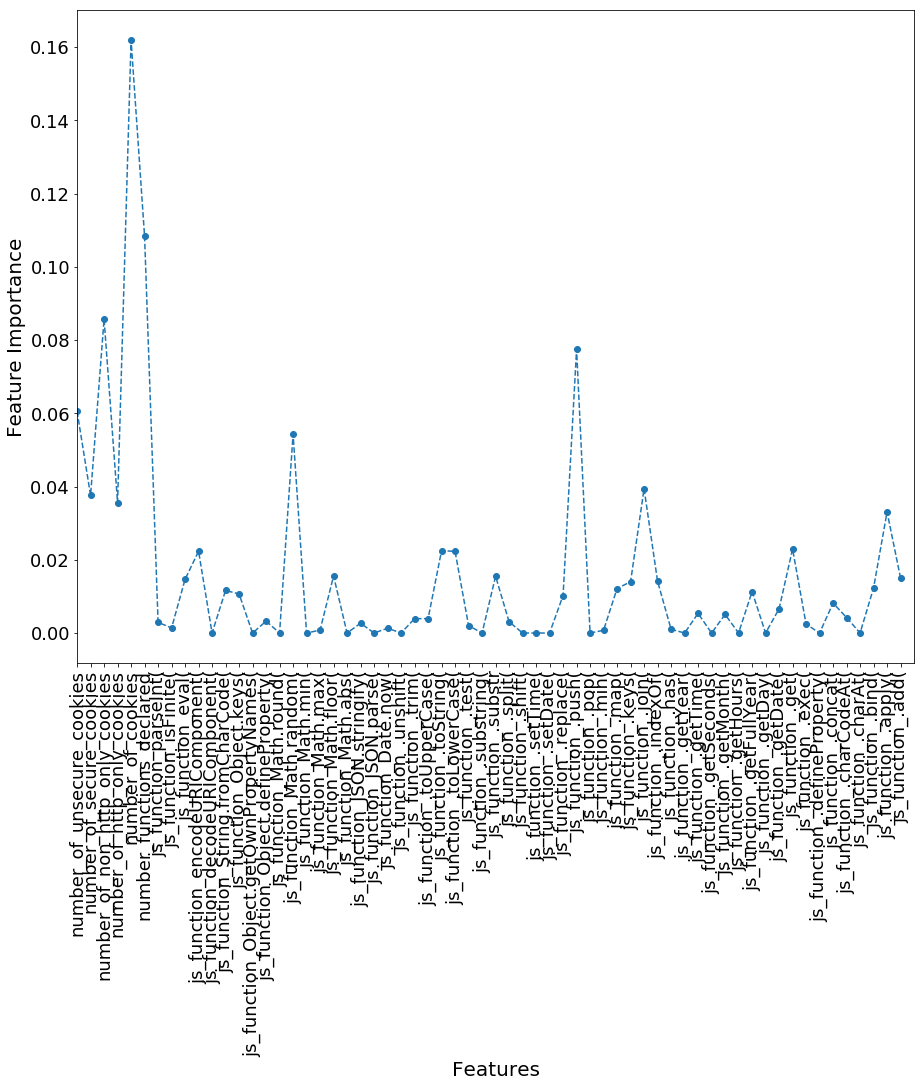

In [106]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 62])
plt.xticks(np.arange(62),feature_name,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### 2.a.b Optimized on f1 score 

##### 2.a.b.a Deep learning

In [108]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=62))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=[f1])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=accuracy_score(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False))
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8792182227221598


Predicted  False  True  __all__
Actual                         
False      26269  3625    29894
True         670  4996     5666
__all__    26939  8621    35560

The accuracy of the model on test data is: 0.8766029246344207


Predicted  False  True  __all__
Actual                         
False       6506   911     7417
True         186  1287     1473
__all__     6692  2198     8890

##### 2.a.b.b GBC

In [109]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_f1(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,5,0.1,150,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.878599550056243

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False      26257  3637    29894
True         680  4986     5666
__all__    26937  8623    35560

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8760404949381327

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6506   911     7417
True         191  1282     1473
__all__     6697  2193     8890

### 2.b. With oversampling using <a href='https://jair.org/index.php/jair/article/view/10302'>SMOTE</a> technique

In [110]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
x_train, X_test, y_train, Y_test = train_test_split(X, y,test_size=0.2,random_state=12)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(x_train, y_train)

#### 2.b.a. Optimized on accuracy

##### 2.b.a.a. Deep Learning

In [111]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=62))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.9108358198967246


Predicted  False   True  __all__
Actual                          
False      25445   4382    29827
True         937  28890    29827
__all__    26382  33272    59654

The accuracy of the model on test data is: 0.8652418447694038


Predicted  False  True  __all__
Actual                         
False       6374  1110     7484
True          88  1318     1406
__all__     6462  2428     8890

##### 2.b.a.b GBC

In [112]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,10,0.1,150,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8993361719247661

Confusion Matrix for Training data is:


Predicted  False   True  __all__
Actual                          
False      25633   4194    29827
True        1811  28016    29827
__all__    27444  32210    59654

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8652418447694038

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6424  1060     7484
True         138  1268     1406
__all__     6562  2328     8890

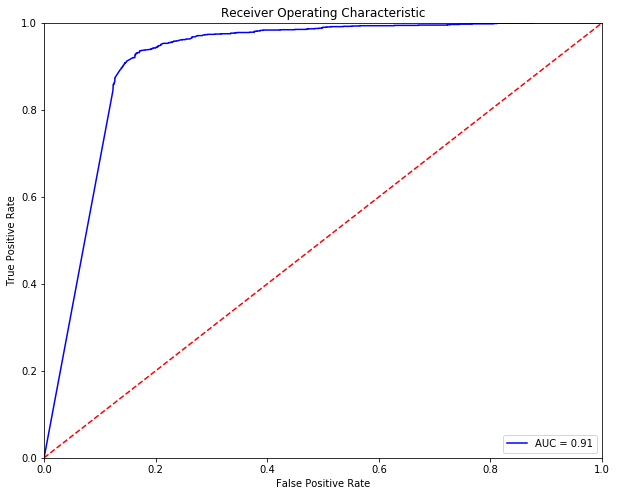

Optimal Threshold is 0.6609904331252259
Accuracy on test data is: 0.8719910011248594


Predicted  False  True  __all__
Actual                         
False       6535   949     7484
True         189  1217     1406
__all__     6724  2166     8890

In [ ]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 62])
plt.xticks(np.arange(62),feature_name,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

### 3. Removing number_of functions

In [12]:
X=df[feature_selection_df[feature_selection_df.Total==4]['Feature']]
X.drop(['number_of_unsecure_cookies','number_of_secure_cookies','number_of_non_http_only_cookies','number_of_http_only_cookies',
       'number_of_cookies'],axis=1,inplace=True)
y=df.Malicious.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(44450, 58)

#### 3.a. Optimized on accuracy

##### 3.a.a.Deep learning

In [14]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=58))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8447412823397076


Predicted  False  True  __all__
Actual                         
False      29843    51    29894
True        5470   196     5666
__all__    35313   247    35560

The accuracy of the model on test data is: 0.837007874015748


Predicted  False  True  __all__
Actual                         
False       7393    24     7417
True        1425    48     1473
__all__     8818    72     8890

##### 3.a.a.b

In [15]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.03,deviance,10,0.1,150,0,0.5


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.84251968503937

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False      29862    32    29894
True        5568    98     5666
__all__    35430   130    35560

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8359955005624297

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7410     7     7417
True        1451    22     1473
__all__     8861    29     8890

#### 3.a.b. With undersampling

In [16]:
df_non=df[df.Malicious==0]
df_mal=df[df.Malicious==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Malicious.value_counts()

1    7139
0    7139
Name: Malicious, dtype: int64

In [17]:
X=df[feature_selection_df[feature_selection_df.Total==4]['Feature']]
X.drop(['number_of_unsecure_cookies','number_of_secure_cookies','number_of_non_http_only_cookies','number_of_http_only_cookies',
       'number_of_cookies'],axis=1,inplace=True)
y=df.Malicious.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(44450, 58)

##### 3.a.b.a Deep Learning

In [18]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=58))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8449662542182227


Predicted  False  True  __all__
Actual                         
False      29850    44    29894
True        5469   197     5666
__all__    35319   241    35560

The accuracy of the model on test data is: 0.8363329583802025


Predicted  False  True  __all__
Actual                         
False       7389    28     7417
True        1427    46     1473
__all__     8816    74     8890

##### 3.a.b.b. GBC

In [19]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.03,deviance,10,0.1,150,0,0.5


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.84251968503937

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False      29862    32    29894
True        5568    98     5666
__all__    35430   130    35560

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8359955005624297

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7410     7     7417
True        1451    22     1473
__all__     8861    29     8890

### 3.a.c With oversampling

In [20]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
x_train, X_test, y_train, Y_test = train_test_split(X, y,test_size=0.2,random_state=12)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(x_train, y_train)

##### 3.a.c.a. Deep Learning

In [21]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=58))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8889596674134306


Predicted  False   True  __all__
Actual                          
False      23764   6063    29827
True         561  29266    29827
__all__    24325  35329    59654

The accuracy of the model on test data is: 0.8237345331833521


Predicted  False  True  __all__
Actual                         
False       5973  1511     7484
True          56  1350     1406
__all__     6029  2861     8890

##### 3.a.c.b GBC

In [22]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1],n_estimators=[100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,5,0.1,150,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8789519562812217

Confusion Matrix for Training data is:


Predicted  False   True  __all__
Actual                          
False      24232   5595    29827
True        1626  28201    29827
__all__    25858  33796    59654

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8296962879640045

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6087  1397     7484
True         117  1289     1406
__all__     6204  2686     8890

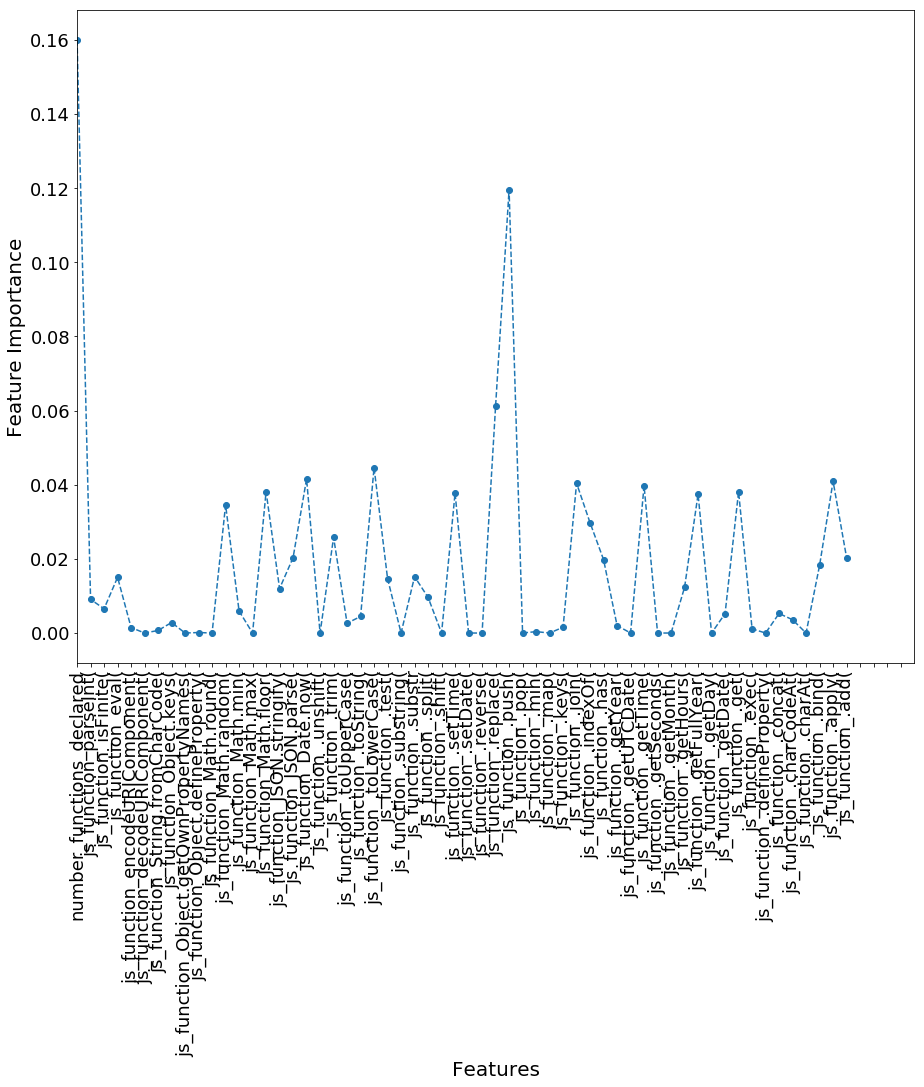

In [25]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 62])
plt.xticks(np.arange(62),feature_name,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()